In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
from deepy.dataset import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = \
    mnist.load_mnist(flatten=False, normalize=False)

In [6]:
X_train = X_train.reshape(-1, 1*28*28)
X_test = X_test.reshape(-1, 1*28*28)

In [9]:
X_train = X_train.astype('float') / 255.0
X_test = X_test.astype('float') / 255.0

데이터에 대해 처음으로 적용할만한 모델은 선형모델입니다.

In [10]:
from sklearn.linear_model import SGDClassifier

대용량 고차원 데이터셋에 대한 로지스틱 회귀

In [12]:
logreg = SGDClassifier(loss='log', tol=1e-4).fit(
    X_train, y_train)

In [15]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.92048333333333332, 0.91559999999999997)

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
forest = RandomForestClassifier().fit(X_train, y_train)
forest.score(X_train, y_train), forest.score(X_test, y_test)

(0.99934999999999996, 0.94999999999999996)

# 손실함수



In [29]:
def 평균제곱오차(y_pred, y):
    """회귀용 손실함수"""
    return 0.5 * np.sum((y-y_pred)**2)

In [21]:
mse = mean_squared_error = 평균제곱오차

In [28]:
y = 1.2
mse(1.2, y), mse(1.1, y), mse(0.5, y)

(0.0, 0.0049999999999999871, 0.24499999999999997)

In [96]:
def cross_entroy_error(y_pred, y):
    """분류용 손실함수"""
    delta = 1e-7 # 아주 작은 값.     
    return -np.sum(y * np.log(y_pred + delta))

def cross_entropy_error_batch(y_pred, y):
    batch_size = len(y)
    cse = cross_entroy_error(y_pred, y) / batch_size
    return cse

In [35]:
y = np.array([0, 1, 0])
y_pred1 = np.array([0.1, 0.7, 0.2])
y_pred2 = np.array([0.7, 0.1, 0.2])
y_pred3 = np.array([0.2, 0.6, 0.2])

In [36]:
cross_entroy_error(y_pred1, y)

0.35667480108159988

In [37]:
cross_entroy_error(y_pred2, y)

2.3025840929945458

In [38]:
cross_entroy_error(y_pred3, y)

0.51082545709933802

### 손실함수 최적화

$$ f(x) = x^2 $$

In [39]:
f = lambda x: x**2

In [44]:
dydx = lambda x: 2*x

In [46]:
def 수치미분(f, x):
    h = 1e-4
    return (f(x+h)-f(x-h)) / (2*h)

numerical_diff = 수치미분

In [40]:
x = np.linspace(-5., 5., 100)

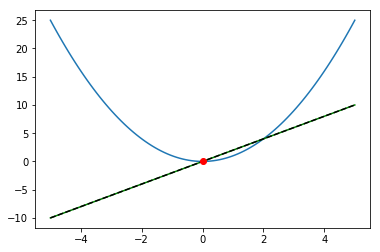

In [47]:
plt.plot(x, f(x))
plt.plot(x, dydx(x), 'g')
plt.plot(x, numerical_diff(f, x), 'k--')
plt.plot(0, 0, 'ro')

$$ f(x_0, x_1) = x_0^2 + x_1^2 $$

In [48]:
f2 = lambda x: np.sum(x**2, 0)

In [49]:
x0 = np.arange(-5, 5, 0.25)
x1 = np.arange(-5, 5, 0.25)

3차원 좌표쌍 생성

In [50]:
X0, X1 = np.meshgrid(x0, x1)

In [51]:
from mpl_toolkits.mplot3d import Axes3D

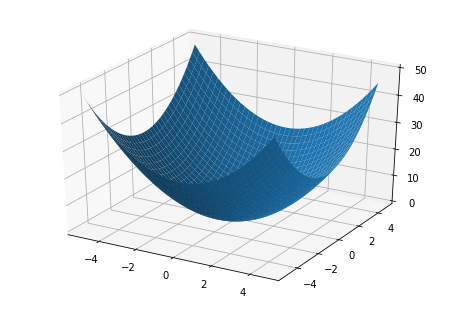

In [52]:
fig = plt.figure() # 그래프 틀 생성
ax = Axes3D(fig) # 3차원 그래프 틀로 설정
ax.plot_surface(X0, X1, f2(np.array([X0, X1])))

### 기울기

Gradient

In [53]:
def 경사산출(f, x):
    h = 1e-4
    경사 = np.zeros_like(x)
    
    # 각 x 축에 대해 경사 산출(미분 수행)
    for i, xi in enumerate(x):
        # f(x+h)
        x[i] = xi + h        
        fxh1 = f(x)
        # f(x-h)
        x[i] = xi - h
        fxh2 = f(x)
        
        경사[i] = (fxh1 - fxh2) / (2*h)
        # 원래 값 복원
        x[i] = xi
        
    return 경사

numerical_gradient = 경사산출

In [55]:
numerical_gradient(f2, np.array([3.0, 4.0]))

array([ 6.,  8.])

In [56]:
numerical_gradient(f2, np.array([0.0, 2.0]))

array([ 0.,  4.])

In [57]:
numerical_gradient(f2, np.array([3.0, 0.0]))

array([ 6.,  0.])

### 경사 하강법

Gradient Descent (GD)

In [61]:
def gradient_descent(f, 출발점, 학습률=0.01, 반복횟수=100):
    x = 출발점.copy()
    
    x_history = [x.copy()]
    for i in range(반복횟수):
        경사 = numerical_gradient(f, x)
        # 하강
        x -= 경사 * 학습률
        x_history.append(x.copy())
    return np.array(x_history)

In [66]:
출발점 = np.array([-3., 4.])
x_history = gradient_descent(f2, 출발점, 학습률=0.1)

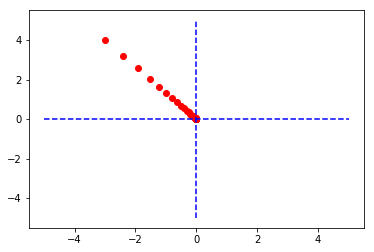

In [67]:
plt.plot(x_history[:, 0], x_history[:, 1], 'ro')
# 보조선
plt.plot([-5, 5], [0, 0], 'b--')
plt.plot([0, 0], [-5, 5], 'b--')

In [68]:
x_opt = x_history[-1]
x_opt

array([ -6.11110793e-10,   8.14814391e-10])

## 신경망 학습

In [97]:
def numerical_gradient_2D(f, X):
    if X.ndim == 1:
        return numerical_gradient(f, X)
    
    # 2차원 행렬인 경우
    grad = np.zeros_like(X)
    for i,x in enumerate(X):
        grad[i] = numerical_gradient(f, x)
        
    return grad


# %load neuralnet.py
import numpy as np

class Layer:
    def __init__(self, 입력수, 출력수, 활성화):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.random.randn(출력수)
        self.활성화 = 활성화
        
    def forward(self, X):
        z = np.dot(X, self.W) + self.b
        return self.활성화(z)
    
    
class FeedForwardNet:
    def __init__(self, loss_func):
        self.layers = []
        self.loss_func = loss_func
        
    def add(self, layer):
        self.layers.append(layer)
        
    def predict(self, X):
        layer_output = X
        for layer in self.layers:
            layer_output = layer.forward(layer_output)
        y = layer_output
        return y
    
    def compute_loss(self, X, y):
        y_pred = self.predict(X)
        loss = self.loss_func(y_pred, y)
        return loss
    
    def fit(self, X, y, 배치크기, 학습률, 학습횟수):
        loss_history = []
        for i in range(학습횟수):
            # 1. 미니배치
            샘플수 = len(X)
            배치색인 = np.random.choice(샘플수, 배치크기)
            X_batch = X[배치색인]
            y_batch = y[배치색인]
            # 2. 기울기 산출
            f = lambda W: self.compute_loss(X_batch, y_batch)
            기울기 = []
            for layer in self.layers:
                dW = numerical_gradient_2D(f, layer.W)
                db = numerical_gradient_2D(f, layer.b)
                기울기.append((dW, db))
            # 3. 매개변수 갱신 (경사하강법)
            for layer, (dW, db) in zip(self.layers, 기울기):
                layer.W -= dW * 학습률
                layer.b -= db * 학습률

            # 손실확인
            loss = self.compute_loss(X_batch, y_batch)
            loss_history.append(loss)
            print('[학습 {}] Loss: {}'.format(i, loss))
        
        return loss_history

In [98]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    y = exp_a / np.sum(exp_a)
    return y

In [99]:
A = np.array([[0.3, 2.9, 4.0],
              [0.3, 2.9, 4.0]])

벡터 단위 함수를 특정 축 방향으로 적용

In [100]:
Y = np.apply_along_axis(arr=A, axis=1, func1d=softmax)

In [101]:
def softmax_batch(A):
    return np.apply_along_axis(arr=A, axis=1, func1d=softmax)

In [102]:
softmax_batch(A)

array([[ 0.01821127,  0.24519181,  0.73659691],
       [ 0.01821127,  0.24519181,  0.73659691]])

In [103]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [114]:
model = FeedForwardNet(loss_func=cross_entropy_error_batch)

model.add(Layer(784, 50, sigmoid))
model.add(Layer(50, 100, sigmoid))
model.add(Layer(100, 10, softmax_batch))

In [115]:
from deepy.dataset import mnist

In [116]:
(X_train, Y_train), (X_test, Y_test) = \
    mnist.load_mnist(flatten=True, normalize=True, 
                     one_hot_label=True)

In [117]:
loss_history = model.fit(X_train, Y_train, 
                         배치크기=100, 학습횟수=600*10, 
                         학습률=0.01)

[학습 0] Loss: 7.531459914763613
[학습 1] Loss: 6.8640430094012315
[학습 2] Loss: 7.020298412023399
[학습 3] Loss: 7.650192910811955
[학습 4] Loss: 7.253063137776539
[학습 5] Loss: 6.554209624206394
[학습 6] Loss: 6.814860501089625
[학습 7] Loss: 6.515421098999724
[학습 8] Loss: 7.361082264370039
[학습 9] Loss: 6.626977262691463
[학습 10] Loss: 6.691670566110798
[학습 11] Loss: 6.160776179907025
[학습 12] Loss: 6.6028051956922305
[학습 13] Loss: 7.277227762029076
[학습 14] Loss: 6.811629229142906
[학습 15] Loss: 6.8831311342068275
[학습 16] Loss: 6.454301572475214
[학습 17] Loss: 6.505832136754886
[학습 18] Loss: 6.414809052502696
[학습 19] Loss: 6.133411747082041
[학습 20] Loss: 6.570664757036932
[학습 21] Loss: 5.664428275242751
[학습 22] Loss: 5.921264493553531
[학습 23] Loss: 6.07344567167247
[학습 24] Loss: 6.250122889177982
[학습 25] Loss: 6.52427398682263
[학습 26] Loss: 6.492203517358647
[학습 27] Loss: 6.143988049408632
[학습 28] Loss: 5.959344253120928
[학습 29] Loss: 6.331279123038699
[학습 30] Loss: 5.2747316446652395
[학습 31] Loss: 5.

KeyboardInterrupt: 

## 1986 오차역전파

In [108]:
class 곱하기:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [109]:
사과단가, 사과개수, 부가세 = 100, 2, 1.1

In [110]:
곱1 = 곱하기()
곱2 = 곱하기()

순전파

In [111]:
사과가격 = 곱1.forward(사과단가, 사과개수)
가격 = 곱2.forward(사과가격, 부가세)
가격

220.00000000000003

역전파

In [112]:
d사과가격, d부가세 = 곱2.backward(dout=1)
d사과단가, d사과개수 = 곱1.backward(dout=d사과가격)
d사과단가, d사과개수

(2.2, 110.00000000000001)

In [113]:
class ReLu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = x > 0
        return np.where(self.mask, x, 0)
    
    def backward(self, dout):
        return np.where(self.mask, 1, 0)